# Local Tool Calling with Ollama

In [51]:
from typing import List
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

In [52]:
load_dotenv(".env")

True

In [53]:
def validate_user(user_id: int, addesses: List ) -> bool:
    return True

def read_databot_values(sensor_names: List) -> List[float]:
    """ Function will read the databot sensor values and return the values"""
    print(sensor_names)
    return [123.45, 42.3]


In [54]:
llm = ChatOllama(
    model= "llama3.1", #"llama3-groq-tool-use",
    temperature=0,
).bind_tools([validate_user, read_databot_values])

In [55]:
result = llm.invoke("Could you validate user 123? They previously lived at 123 Main St, in Mayberry West Virginia and 643 Barrington Street in Halifax, Nova Scotia Canada. In addition can you read the databot values for the databot sensors pressure and humidity?")

In [56]:
result.tool_calls

[{'name': 'validate_user',
  'args': {'addesses': '[{"street": "Main St", "city": "Mayberry", "state": "West Virginia"}, {"street": "Barrington Street", "city": "Halifax", "country": "Canada"}]',
   'user_id': 123},
  'id': 'a9995594-bc41-4dfb-ad96-6f8a6e09f986',
  'type': 'tool_call'},
 {'name': 'read_databot_values',
  'args': {'sensor_names': '["pressure", "humidity"]'},
  'id': '8ceff8ba-4692-49e6-a6f0-fbdda613d746',
  'type': 'tool_call'}]

In [7]:
result = llm.invoke("Can you read the databot values for the databot sensors pressure and humidity?")


In [8]:
result.tool_calls

[{'name': 'read_databot_values',
  'args': {'sensor_names': '["pressure", "humidity"]'},
  'id': '0f842621-62a6-4fab-a37f-cfb448b96e26',
  'type': 'tool_call'}]

## Using LangGraph to build Agent

In [9]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
embeddings = OllamaEmbeddings(model='nomic-embed-text')


In [10]:
llm = ChatOllama(
    model= "llama3.1", #"llama3-groq-tool-use",
    temperature=0,
)

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore


In [12]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm",
]

In [13]:
docs = [WebBaseLoader(url).load() for url in urls]

In [14]:
len(docs)

3

In [15]:
docs_list = [item for sublist in docs for item in sublist]

In [16]:
len(docs_list)

3

In [17]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0,
)

In [18]:
docs_splits = text_splitter.split_documents(docs_list)

In [19]:
len(docs_splits)

194

In [20]:
vector_store = SKLearnVectorStore.from_documents(
    documents=docs_splits,
    embedding=embeddings,
)

In [21]:
retriever = vector_store.as_retriever(k=4)

In [22]:
def retrieve_documents(query: str) -> List:
    """
    Function will retrieve the documents stored in the vector store
    :param query: 
    :return: List of documents
    """
    return retriever.invoke(query)

### Search Tool

In [23]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

In [24]:
web_search_tool = TavilySearchResults()

In [25]:
def web_search(query: str) -> List:
    """
    Function Name: web_search
    This function will will use the TavilySearch API to search the web site
    
    :param query: The tavily search query 
    :return: List of Documents
    """
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d['content'], metadata={"url": d['url']}) for d in web_results
    ]

#### Create 2 Tools

* document retriever tool
* web search tool

In [26]:
tools = [retrieve_documents, web_search]

## Create Assistant

In [27]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langgraph.graph.message import AnyMessage, add_messages

In [28]:
class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [29]:
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
    
    def __call__(self, state: State, config: Runnable):
        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state['messages'] + [{"user", "Respond with a real output."}]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}
    

### Create the primary assistant prompt template

In [30]:
from langchain_core.prompts.chat import ChatPromptTemplate

In [31]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with answering user questions."
            "You have access to two tools: retrieve_documents and web_search."
            "For any user questions about LLM agents, use the retieve_documents tools to get information for a vectorstore."
            "For any other questions, such as questions about current events, use the web_search tool to get information from the web."

        ),
        ("placeholder", "{messages}"),
    ]
)

In [32]:
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [33]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

In [34]:
def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tools_calls = state['messages'][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tools_call_id=tc['id']
            ) for tc in tools_calls
        ]
    }
    
def create_tool_node_with_fallback(tools: List) -> dict:
    res = ToolNode(tools).with_fallbacks(
        fallbacks=[RunnableLambda(handle_tool_error)],
        exception_key="error"
    )
    return res


In [35]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import display, Image

In [36]:
# graph
builder = StateGraph(State)

In [37]:
# Define notes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

In [38]:
# define edges:  these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message ( resuilt) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

In [39]:
memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile(checkpointer=memory)

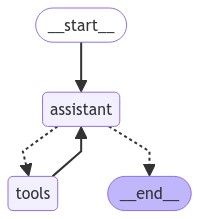

In [40]:
# Show langgraph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

# Invoke

In [41]:
import uuid

def predict_react_agent_answer(example: dict):
    """
    use this for answer evaluation
    
    :param example: 
    :return: 
    """
    config = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
        }
    }
    
    messages = react_graph.invoke({
        "messages": ("user", example['input'])
    }, config)
    
    return {"response": messages['messages'][-1].content, "messages": messages}


In [42]:
example = {
    "input": "Get me information about the types of LLLM agent memory"
}


In [43]:
response = predict_react_agent_answer(example)

In [46]:
print(response['response'])

Based on the documents retrieved, there are several types of memory that can be used in LLM-powered autonomous agents:

1. **Sensory Memory**: This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds.
2. **Maximum Inner Product Search (MIPS)**: MIPS is a type of memory that can be used in LLM-powered autonomous agents. It allows for fast and efficient search through large datasets.

These types of memory can be used in combination with other components, such as planning and tool use, to create a robust and effective LLM-powered autonomous agent system.


In [48]:
example = {
    "input": "What is the weather in Chicago Illinois US"
}
response = predict_react_agent_answer(example)
print(response['response'])

Based on the web search results, it appears that there are various sources providing information about the weather in Chicago, Illinois, US.

According to WeatherAPI (https://www.weatherapi.com/), the current weather conditions in Chicago are:

* Temperature: 23.4°C (74.1°F)
* Condition: Patchy rain nearby
* Wind speed: 7.4 mph (11.9 km/h) from the northeast

Additionally, AccuWeather (https://www.accuweather.com/en/us/chicago/60608/running-july-weather/348308) provides a monthly weather forecast for Chicago in July 2024, which includes daily high and low temperatures, historical averages, and precipitation information.

Weather.com (https://weather.com/weather/monthly/l/Chicago+IL?canonicalCityId=51327091448a763db3e0093b240009381d87952467e6c2ba8bad55f1328ec986) also provides a monthly weather forecast for Chicago in July 2024, including average and record temperatures, precipitation, and more.

World-Weather.info (https://world-weather.info/forecast/usa/chicago/july-2024/) provides a 